# Stratification

Vamos começar com o conceito de estratificação dando um exemplo em que podemos ter problemas se não formos cuidadosos. 

Vamos carregar o conjunto de dados da íris.

In [1]:
from sklearn.datasets import load_iris

data, target = load_iris(as_frame=True, return_X_y=True)

Neste ponto, criamos um modelo básico de aprendizado de máquina: uma regressão logística. Esperamos que este modelo funcione muito bem no conjunto de dados da íris, uma vez que se trata de um conjunto de dados de brinquedo.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Depois de criar nosso modelo, usaremos a estrutura de validação cruzada para avaliá-lo. Usaremos a `KFold` estratégia de validação cruzada. Vamos definir um conjunto de dados com nove amostras e repetir a validação cruzada três vezes (ou seja `n_splits`).

In [3]:
import numpy as np
from sklearn.model_selection import KFold

data_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(data_random):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]


Definindo três divisões, usaremos três amostras para teste e seis para treinamento de cada vez. `KFold` não embaralha por padrão. Isso significa que ele selecionará as três primeiras amostras para o conjunto de teste na primeira divisão, depois as três próximas três amostras para a segunda divisão e as três próximas para a última divisão. No final, todas as amostras foram usadas em testes pelo menos uma vez entre as diferentes divisões.

Agora, vamos aplicar esta estratégia para verificar o desempenho de generalização de nosso modelo.

In [4]:
from sklearn.model_selection import cross_validate

cv = KFold(n_splits=3)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.000 +/- 0.000


É uma surpresa real que nosso modelo não pode classificar corretamente qualquer amostra em qualquer divisão de validação cruzada. Vamos agora verificar o valor do nosso alvo para entender o problema.

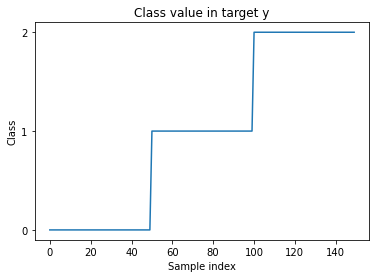

In [5]:
import matplotlib.pyplot as plt

target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

Vemos que o vetor de destino targetestá ordenado. Isso terá algumas consequências inesperadas ao usar a `KFold`validação cruzada. Para ilustrar as consequências, mostraremos a contagem de classes em cada dobra da validação cruzada no trem e no conjunto de teste.

Vamos calcular as contagens de classe para os conjuntos de treinamento e teste usando a `KFold` validação cruzada e plotar essas informações em um gráfico de barra.

Iremos iterar de acordo com o número de divisões e verificar quantas amostras de cada uma estão presentes no conjunto de treinamento e teste. Armazenaremos as informações em duas listas distintas; um para o conjunto de treinamento e outro para o conjunto de teste.

In [6]:
import pandas as pd

n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

Para plotar as informações em uma única figura, vamos concatenar as informações sobre a dobra no mesmo conjunto de dados.

In [7]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
train_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,NaN,50.0,50.0
1,50.0,NaN,50.0
2,50.0,50.0,NaN


In [8]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Class label"
test_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


Agora podemos representar graficamente essas informações com gráficos de barras.

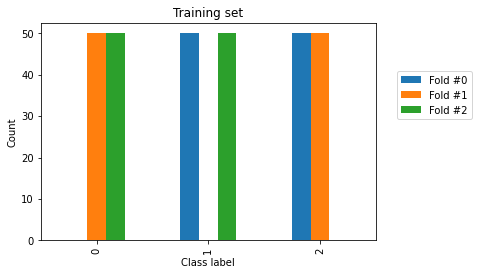

In [9]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

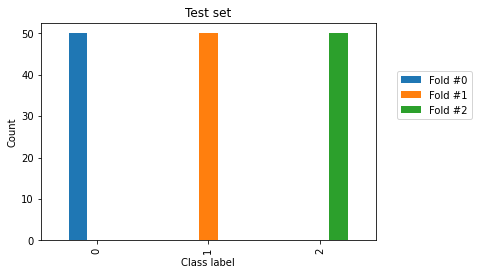

In [10]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

Podemos confirmar que em cada dobra, apenas duas das três classes estão presentes no conjunto de treinamento e todas as amostras da classe restante são usadas como um conjunto de teste. Portanto, nosso modelo não é capaz de prever essa aula que não foi vista durante o estágio de treinamento.

Uma possibilidade de resolver o problema é embaralhar os dados antes de dividi-los em três grupos.

In [11]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.953 +/- 0.009


Obtemos resultados mais próximos do que esperaríamos com uma precisão acima de 90%. Agora que resolvemos nosso primeiro problema, seria interessante verificar se a frequência de aula no conjunto de treinamento e teste é igual à frequência de aula em nosso conjunto original. Isso garantiria que estamos treinando e testando nosso modelo com uma distribuição de classes que encontraremos na produção.

In [12]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

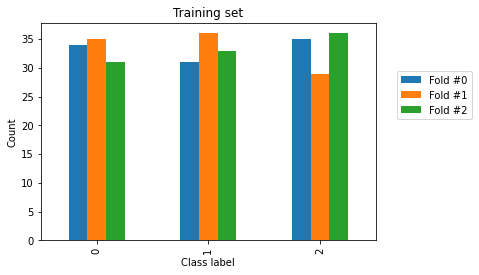

In [13]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

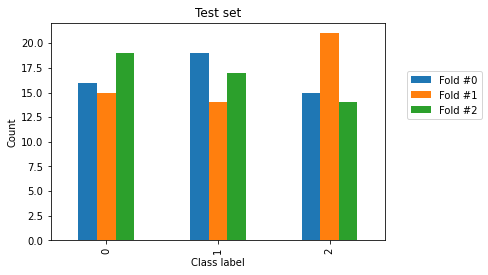

In [14]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

Nesse caso, observamos que as contagens de classes são muito próximas tanto no conjunto de trens quanto no conjunto de teste. A diferença se deve ao pequeno número de amostras no conjunto de dados da íris.

Em conclusão, esta é uma boa prática para usar estratificação dentro da estrutura de validação cruzada ao lidar com um problema de classificação.